# Sparkify Project Workspace
This workspace contains a subset (based on the IBM subset) of the full dataset. Since my company does not use Spark and I prefere coding normal I used the bigger IBM subset and coded without spark. 

Importing libaries and subset

In [1]:
# import libraries
import numpy as np
from matplotlib import pyplot
import pandas as pd
import seaborn as sns
import json
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [2]:
df=pd.read_json(r'medium-sparkify-event-data.json', lines=True)

In [3]:
#df=pd.read_json(r'mini_sparkify_event_data.json', lines=True)

In [4]:
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,NaN,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,NaN,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


Theory: possible churn indicators based on dataset
1. ration thumbs up vs down or count e.g. to identify if he liked the music available or not
2. hours logged in  e.g. did he listened to all songs already?
3. Songs played & author e.g. does he enjoy a lot of music or just one album 
4. gender differences 

Indicators that could be beneficial: 
1. Thumbs up 
2. Thumbs down 
3. Songs played
4. Gender
5. Artists
6. total length 
7. level

# Exploring data in more detail

For exploring the data we will do multiple steps: 

0. Handling NaNs
1. Check some more features for unique values to understand the sample even better 
2. Define what is churn in our dataset based on the understanding we have now 
3. Drop unnecessary data columns (based on what defined so far and on what the goal is and the described indicators at the top
4. checking the remaining data and visualize it (especially the important features to figure out if there are differences between churned users and not churned users
5. Build the different models and use them to predict churn 

## 0.Let's have a first look at the dataset & handle NaNs

Unique User in dataset 

In [5]:
df['userId'].nunique()

449

Checking Data and content 

In [6]:
df.groupby('lastName').count().head()

,artist,auth,firstName,gender,itemInSession,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
lastName,,,,,,,,,,,,,,,,,
Abbott,89,131,131,131,131,89,131,131,131,131,131,131,89,131,131,131,131
Adams,11,17,17,17,17,11,17,17,17,17,17,17,11,17,17,17,17
Aguilar,775,998,998,998,998,775,998,998,998,998,998,998,775,998,998,998,998
Alexander,2134,2622,2622,2622,2622,2134,2622,2622,2622,2622,2622,2622,2134,2622,2622,2622,2622
Allen,4173,5076,5076,5076,5076,4173,5076,5076,5076,5076,5076,5076,4173,5076,5076,5076,5076


In [7]:
df.groupby('auth').count()

,artist,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
auth,,,,,,,,,,,,,,,,,
Cancelled,0,99,99,99,99,0,99,99,99,99,99,99,0,99,99,99,99
Guest,0,0,0,94,0,0,94,0,94,94,0,94,0,94,94,0,94
Logged In,432877,527906,527906,527906,527906,432877,527906,527906,527906,527906,527906,527906,432877,527906,527906,527906,527906
Logged Out,0,0,0,15606,0,0,15606,0,15606,15606,0,15606,0,15606,15606,0,15606


In [8]:
pd.crosstab(index=df["page"], columns="count")

col_0,count
page,
About,1855
Add Friend,8087
Add to Playlist,12349
Cancel,99
Cancellation Confirmation,99
Downgrade,3811
Error,519
Help,3150
Home,27412


In [9]:
df.isna().sum()

artist           110828
auth                  0
firstName         15700
gender            15700
itemInSession         0
lastName          15700
length           110828
level                 0
location          15700
method                0
page                  0
registration      15700
sessionId             0
song             110828
status                0
ts                    0
userAgent         15700
userId                0
dtype: int64

In [10]:
df.head(286496) 

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,NaN,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,NaN,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246
5,Carter USM,Logged In,Sofia,F,266,Gordon,138.29179,paid,"Rochester, MN",PUT,NextSong,1.533176e+12,162,Airplane Food,200,1538352125000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",163
6,NaN,Logged Out,NaN,NaN,186,NaN,NaN,paid,NaN,GET,Home,NaN,178,NaN,200,1538352148000,NaN,
7,NaN,Logged Out,NaN,NaN,187,NaN,NaN,paid,NaN,GET,Home,NaN,178,NaN,200,1538352151000,NaN,
8,NaN,Logged Out,NaN,NaN,188,NaN,NaN,paid,NaN,GET,Home,NaN,178,NaN,200,1538352168000,NaN,
9,NaN,Logged Out,NaN,NaN,189,NaN,NaN,paid,NaN,PUT,Login,NaN,178,NaN,307,1538352169000,NaN,


Finding: looks like we have NAN even if it is not shown (e.g. line 286496 - userId is empty)

In [11]:
# some have no info but are not listed as nan, so lets make it visible
df=df.replace(r'', np.nan, regex=True)

In [12]:
df['Name'] = df['firstName'].str.cat(df['lastName'],sep=" ")

In [13]:
dict4=pd.Series(df.Name.values,index=df.userId).to_dict()

In [14]:
# filling User ID 
df['userId']=df['userId'].fillna(df['Name'].map(dict4))

In [15]:
df.isna().sum()

artist           110828
auth                  0
firstName         15700
gender            15700
itemInSession         0
lastName          15700
length           110828
level                 0
location          15700
method                0
page                  0
registration      15700
sessionId             0
song             110828
status                0
ts                    0
userAgent         15700
userId            15700
Name              15700
dtype: int64

Lets continue understanding the data

In [16]:
df.groupby('auth').describe()

itemInSession                                                   \
                   count        mean         std  min   25%   50%     75%   
auth                                                                        
Cancelled           99.0   92.131313  100.989861  3.0  23.5  55.0  118.50   
Guest               94.0   10.053191   10.837378  0.0   2.0   6.0   14.75   
Logged In       527906.0  107.781929  116.867448  0.0  27.0  68.0  148.00   
Logged Out       15606.0   91.898885  110.851603  0.0  15.0  53.0  128.00   

                      length                  ...      status         \
               max     count        mean      ...         75%    max   
auth                                          ...                      
Cancelled    460.0       0.0         NaN      ...       200.0  200.0   
Guest         38.0       0.0         NaN      ...       200.0  404.0   
Logged In   1005.0  432877.0  248.664593      ...       200.0  404.0   
Logged Out   925.0       0.0         NaN      ...       307.0  404.0   

                  ts                                                          \
               count          mean           std           min           25%   
auth                                                                           
Cancelled       99.0  1.540849e+12  1.576659e+09  1.538401e+12  1.539149e+12   
Guest           94.0  1.542194e+12  1.216307e+09  1.538790e+12  1.541982e+12   
Logged In   527906.0  1.540967e+12  1.481215e+09  1.538352e+12  1.539723e+12   
Logged Out   15606.0  1.540876e+12  1.505522e+09  1.538352e+12  1.539608e+12   

                                                      
                     50%           75%           max  
auth                                                  
Cancelled   1.541087e+12  1.542132e+12  1.543583e+12  
Guest       1.542867e+12  1.542868e+12  1.543613e+12  
Logged In   1.541007e+12  1.542178e+12  1.543622e+12  
Logged Out  1.540915e+12  1.542105e+12  1.543622e+12  

[4 rows x 48 columns]

Finding: 
After logout no information (e.g. length) and a lot of NaNs (see also line 14)
Sum NaNs= Sum of LoggedOut + Sum of Guests

Two Options for NaN:
1. Delete data because it's a lot data after logout 
2. forward fill missing information

I will  delete the NaN data because we are looking at churn. Users that are not logged-in and/or guests can't churn, therefore these data should not be useful for prediction when users are churning (based on this data set). 

-> Additional Value of ff is low.

I will not delete all NaNs but only for userId and sessionId because we have to check if we could use it later on. I prefer to not delete to much data to early. 

In [17]:
df=df.dropna(how='any', subset=['userId', "sessionId"])
df.isna().sum()

artist           95128
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           95128
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             95128
status               0
ts                   0
userAgent            0
userId               0
Name                 0
dtype: int64

## 1. Understand data

In [18]:
df['status'].unique()

array([200, 307, 404])

In [19]:
df['gender'].unique()

array(['M', 'F'], dtype=object)

In [20]:
df['level'].unique()

array(['free', 'paid'], dtype=object)

In [21]:
df['artist'].unique()

array(['Martin Orford', "John Brown's Body", 'Afroman', ...,
       'Hot Club Of Cowtown',
       "Fun Lovin' Criminals Featuring Ian McCulloch", 'Armand Amar'], dtype=object)

In [22]:
df['page'].unique()

array(['NextSong', 'Logout', 'Home', 'Downgrade', 'Add to Playlist',
       'Roll Advert', 'Thumbs Up', 'Help', 'Thumbs Down', 'Add Friend',
       'Settings', 'Save Settings', 'Upgrade', 'About', 'Submit Downgrade',
       'Cancel', 'Cancellation Confirmation', 'Submit Upgrade', 'Error'], dtype=object)

## 2. Define Churn

In [23]:
df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,528005.000000,432877.000000,5.280050e+05,528005.000000,528005.000000,5.280050e+05
mean,107.778995,248.664593,1.535523e+12,2042.980182,209.091062,1.540967e+12
std,116.864787,98.412670,3.078725e+09,1433.998149,30.148778,1.481233e+09
min,0.000000,0.783220,1.509854e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.392200,1.534368e+12,632.000000,200.000000,1.539723e+12
50%,68.000000,234.004440,1.536556e+12,1973.000000,200.000000,1.541007e+12
75%,148.000000,276.793020,1.537612e+12,3310.000000,200.000000,1.542178e+12
max,1005.000000,3024.665670,1.543074e+12,4808.000000,404.000000,1.543622e+12


In [24]:
df['page'].unique()

array(['NextSong', 'Logout', 'Home', 'Downgrade', 'Add to Playlist',
       'Roll Advert', 'Thumbs Up', 'Help', 'Thumbs Down', 'Add Friend',
       'Settings', 'Save Settings', 'Upgrade', 'About', 'Submit Downgrade',
       'Cancel', 'Cancellation Confirmation', 'Submit Upgrade', 'Error'], dtype=object)

I define that a user is churning when a customer confirms cancellation. I don't use here the Submit Downgrade because I would have to control for reupgrade and users that first downgrade and later cancle. Otherwise a user could have multiple churn events and change the overall churn score 

In [25]:
dict={'NextSong':0, 'Add to Playlist':0, 'Roll Advert':0, 'Thumbs Up':0,
       'Downgrade':0, 'Thumbs Down':0, 'Home':0, 'Logout':0, 'Help':0, 'Login':0,
       'Upgrade':0, 'Add Friend':0, 'About':0, 'Settings':0, 'Submit Upgrade':0,
       'Submit Downgrade':0, 'Error':0, 'Save Settings':0, 'Cancel':0,
       'Cancellation Confirmation':1, 'Register':0, 'Submit Registration':0}
dict

{'NextSong': 0,
 'Add to Playlist': 0,
 'Roll Advert': 0,
 'Thumbs Up': 0,
 'Downgrade': 0,
 'Thumbs Down': 0,
 'Home': 0,
 'Logout': 0,
 'Help': 0,
 'Login': 0,
 'Upgrade': 0,
 'Add Friend': 0,
 'About': 0,
 'Settings': 0,
 'Submit Upgrade': 0,
 'Submit Downgrade': 0,
 'Error': 0,
 'Save Settings': 0,
 'Cancel': 0,
 'Cancellation Confirmation': 1,
 'Register': 0,
 'Submit Registration': 0}

In [26]:
df['Churn']=df['page'].map(dict)
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Name,Churn
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293,Joseph Morales,0
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98,Sawyer Larson,0
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179,Maverick Santiago,0
3,NaN,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,NaN,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179,Maverick Santiago,0
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246,Gianna Campos,0


In [27]:
df['Churn'].sum()

99

In [28]:
churn_rate=df['Churn'].sum()/df['userId'].nunique()
churn_rate

0.22098214285714285

## 3.Drop unnecessary features 

For the further analysis I will drop a couple of columns: 
1. auth - no additional information (since we dropped guests and data after log-out)
2. firstName (we have the user ID as a unique identifyer and the name should not have an effect on churn behaviour)
3. lastName (we have the user ID as a unique identifyer)
4. location - location should not have an effect on churn behaviour in general
5. method - internal information, not important for customer
6. song will be dropped later- songname is not important, only amount of songs
7. userAgent - based on the user preference and should not have an effect (only if our dev.-team did not optimise for all systems / browsers - I assume they did) 
8. Name (we have the user ID as a unique identifyer)

In [29]:
df=df.drop(['auth','firstName','lastName', 'location', 'method','userAgent', 'Name'],axis=1)
df.head(1)

,artist,gender,itemInSession,length,level,page,registration,sessionId,song,status,ts,userId,Churn
0,Martin Orford,M,20,597.55057,free,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,293,0


In [30]:
df[df["Churn"] == 1].head()

,artist,gender,itemInSession,length,level,page,registration,sessionId,song,status,ts,userId,Churn
2555,NaN,F,40,NaN,free,Cancellation Confirmation,1.536758e+12,490,NaN,200,1538400616000,208,1
6758,NaN,F,234,NaN,paid,Cancellation Confirmation,1.533473e+12,471,NaN,200,1538482793000,231,1
12652,NaN,M,109,NaN,paid,Cancellation Confirmation,1.529996e+12,682,NaN,200,1538539871000,236,1
16350,NaN,M,66,NaN,free,Cancellation Confirmation,1.533888e+12,628,NaN,200,1538592529000,156,1
29338,NaN,M,227,NaN,paid,Cancellation Confirmation,1.535619e+12,395,NaN,200,1538770077000,271,1


52 users chruned (see higher) 

## 4. Check and visualise data 

In [31]:
df['artist'].nunique()

21247

In [32]:
df['level'].unique()

array(['free', 'paid'], dtype=object)

In [33]:
df['sessionId'].nunique()

4470

In [34]:
df['userId'].nunique()

448

In [35]:
df['status'].unique()

array([200, 307, 404])

In [36]:
helper=df[df['Churn']==1].drop_duplicates()

In [37]:
cancled=helper['userId'].tolist()

In [38]:
dict1=dict.fromkeys(cancled,1)


In [39]:
df['Churned']=df['userId'].map(dict1)


In [40]:
df['Churned']=df['Churned'].fillna(value=0)
df.head()

,artist,gender,itemInSession,length,level,page,registration,sessionId,song,status,ts,userId,Churn,Churned
0,Martin Orford,M,20,597.55057,free,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,293,0,1.0
1,John Brown's Body,M,74,380.21179,free,NextSong,1.538070e+12,97,Bulls,200,1538352025000,98,0,0.0
2,Afroman,M,184,202.37016,paid,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,179,0,0.0
3,NaN,M,185,NaN,paid,Logout,1.535953e+12,178,NaN,307,1538352119000,179,0,0.0
4,Lily Allen,F,22,194.53342,paid,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,246,0,1.0


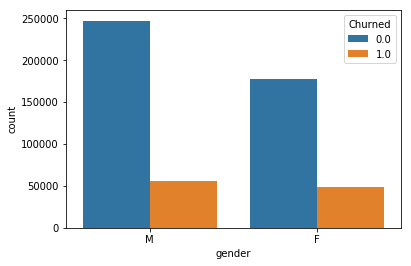

In [41]:
sns.countplot(x="gender", hue="Churned", data=df);

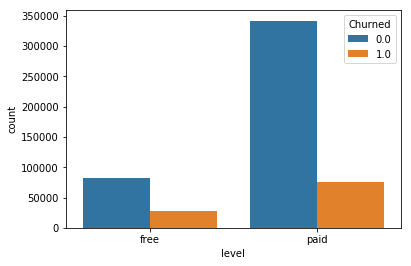

In [42]:
sns.countplot(x="level", hue="Churned", data=df);

Engineering additional features

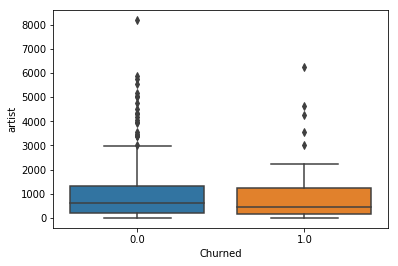

In [43]:
artists=df.groupby('userId').agg({"artist": "count"})
artists1=df.groupby('userId').agg({'Churned' : 'max'})
artists=artists.join(artists1)

sns.boxplot(x="Churned", y='artist', data=artists);

In [44]:
artists=artists.rename(columns={'artists':'artists', 'Churned':'Churnedartists'})

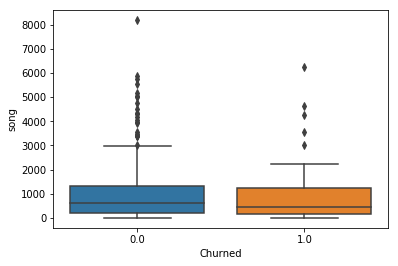

In [45]:
song=df.groupby('userId').agg({"song": "count"})
song1=df.groupby('userId').agg({'Churned' : 'max'})
song=song.join(song1)

sns.boxplot(x="Churned", y= 'song', data=song);


In [46]:
song=song.rename(columns={'song':'song', 'Churned':'Churnedasong'})


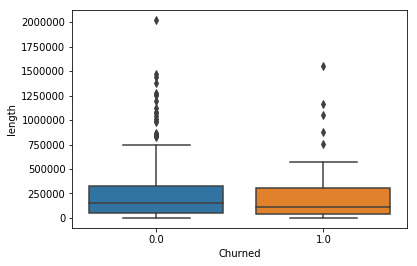

In [47]:
length=df.groupby('userId').agg({"length": "sum"})
length1=df.groupby('userId').agg({'Churned' : 'max'})
length=length.join(length1)

sns.boxplot(x="Churned", y= 'length', data=length)

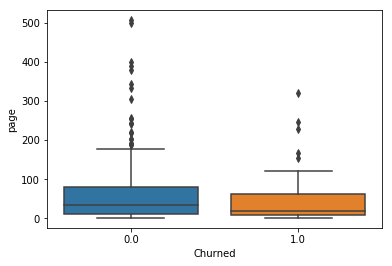

In [48]:
up=df[df['page']=='Thumbs Up'].groupby('userId').agg({"page": "count"})
up1=df.groupby('userId').agg({'Churned' : 'max'})
up=up.join(up1)

sns.boxplot(x="Churned", y= 'page', data=up);

In [49]:
up=up.rename(columns={'page':'up', 'Churned':'Churnedup'})
up.head()

,up,Churnedup
userId,,
10,17,1.0
100,143,0.0
100001,5,1.0
100002,8,0.0
100003,16,1.0


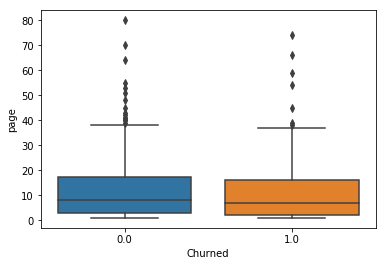

In [50]:
down=df[df['page']=='Thumbs Down'].groupby('userId').agg({"page": "count"})
down1=df.groupby('userId').agg({'Churned' : 'max'})
down=down.join(down1)

sns.boxplot(x="Churned", y='page', data=down);

### Preparation for the model 

In [51]:
down=down.rename(columns={'page':'down', 'Churned':'Churneddown'})
down.head()

,down,Churneddown
userId,,
10,1,1.0
100,37,0.0
100001,1,1.0
100002,2,0.0
100003,10,1.0


In [52]:
up.head()

,up,Churnedup
userId,,
10,17,1.0
100,143,0.0
100001,5,1.0
100002,8,0.0
100003,16,1.0


In [53]:
gender=df.groupby('userId').agg({"gender": "max"})
gender.head()

,gender
userId,
10,M
100,M
100001,F
100002,F
100003,F


In [54]:
level=df.groupby('userId').agg({"level": "max"})
level.head()

,level
userId,
10,paid
100,paid
100001,free
100002,paid
100003,paid


In [55]:
merged_df=pd.concat([up,down,gender,song, level,artists,length,], axis=1, sort=False)
merged_df=merged_df.drop(['Churnedup','Churneddown','Churnedasong','Churnedartists'],axis=1)
merged_df.head()

,up,down,gender,song,level,artist,length,Churned
10,17.0,1.0,M,360,paid,360,90524.44076,1.0
100,143.0,37.0,M,3382,paid,3382,829748.33112,0.0
100001,5.0,1.0,F,96,free,96,23795.33930,1.0
100002,8.0,2.0,F,137,paid,137,36769.06108,0.0
100003,16.0,10.0,F,661,paid,661,162292.65050,1.0


In [56]:
merged_df.isna().sum()

up          9
down       59
gender      0
song        0
level       0
artist      0
length      0
Churned     0
dtype: int64

In [57]:
merged_df=merged_df.fillna(0)
merged_df.isna().sum()

up         0
down       0
gender     0
song       0
level      0
artist     0
length     0
Churned    0
dtype: int64

Getting Dummies for Gender and level 

In [58]:
merged_df=pd.get_dummies(data=merged_df, columns=['gender', 'level'],drop_first=True )
merged_df.head()

,up,down,song,artist,length,Churned,gender_M,level_paid
10,17.0,1.0,360,360,90524.44076,1.0,1,1
100,143.0,37.0,3382,3382,829748.33112,0.0,1,1
100001,5.0,1.0,96,96,23795.33930,1.0,0,0
100002,8.0,2.0,137,137,36769.06108,0.0,0,1
100003,16.0,10.0,661,661,162292.65050,1.0,0,1


## 5. Building the models and testing 

3 approaches will be compared: 
1. Regression model
2. Random forest model 
3. Gradient boosting 

### 1. Regression model

In [59]:
X=merged_df.drop('Churned',axis=1)
y=merged_df['Churned']

In [60]:
X.head()

,up,down,song,artist,length,gender_M,level_paid
10,17.0,1.0,360,360,90524.44076,1,1
100,143.0,37.0,3382,3382,829748.33112,1,1
100001,5.0,1.0,96,96,23795.33930,0,0
100002,8.0,2.0,137,137,36769.06108,0,1
100003,16.0,10.0,661,661,162292.65050,0,1


In [61]:
y.head()

10        1.0
100       0.0
100001    1.0
100002    0.0
100003    1.0
Name: Churned, dtype: float64

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [63]:
# log regression

In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
model= LogisticRegression(C=1.0,class_weight='balanced', warm_start=False,
                   tol=0.0001,multi_class='ovr',intercept_scaling=1)

In [66]:
model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [67]:
predictions = model.predict(X_test)


In [68]:
print( classification_report(y_test, predictions) )


             precision    recall  f1-score   support

        0.0       0.85      0.66      0.74       102
        1.0       0.38      0.64      0.47        33

avg / total       0.73      0.65      0.67       135



In [69]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

[[67 35]
 [12 21]]


In [70]:
model.coef_

array([[ -1.27604110e-02,   4.79028124e-02,  -5.77657015e-03,
         -5.77657015e-03,   4.68067593e-05,  -1.37282952e-03,
          1.19482684e-02]])

In [71]:
f1_score(y_test,predictions,average='weighted')

0.67471737675971322

### 2. Random Forest 

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [74]:
rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
rfc_pred=rfc.predict(X_test)

In [75]:
f1_score(y_test,rfc_pred,average='weighted')

0.65291005291005277

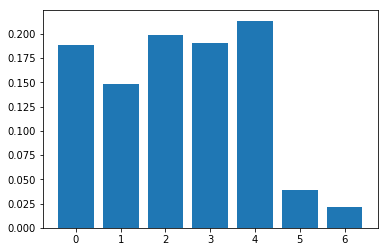

In [76]:
pyplot.bar(range(len(rfc.feature_importances_)), rfc.feature_importances_)
pyplot.show()

### 3.Gradient Boosting Classifier

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [79]:
gbt=GradientBoostingClassifier()
gbt.fit(X_train,y_train)
gbt_pred=gbt.predict(X_test)

In [80]:
f1_score(y_test,gbt_pred,average='weighted')

0.69744346116027522

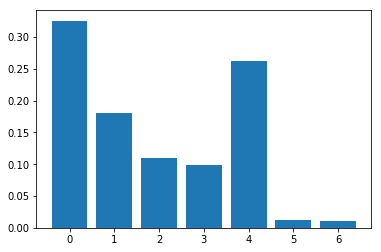

In [81]:
pyplot.bar(range(len(gbt.feature_importances_)), gbt.feature_importances_)
pyplot.show()

In [82]:
X.head()

,up,down,song,artist,length,gender_M,level_paid
10,17.0,1.0,360,360,90524.44076,1,1
100,143.0,37.0,3382,3382,829748.33112,1,1
100001,5.0,1.0,96,96,23795.33930,0,0
100002,8.0,2.0,137,137,36769.06108,0,1
100003,16.0,10.0,661,661,162292.65050,0,1


Tuning - example Random Forest 

In [83]:
from sklearn.model_selection import GridSearchCV, train_test_split


In [84]:
grid_param = {'n_estimators': [50,75,100, 300, 500],'max_depth':[10,50,75,100,300]}

In [85]:
gd_sr = GridSearchCV(estimator=rfc,param_grid=grid_param,scoring='f1',n_jobs=-1)
gd_sr.fit(X_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)
rfc=RandomForestClassifier(n_estimators=(best_parameters['n_estimators']),max_depth=(best_parameters['max_depth']))
rfc.fit(X_train,y_train)
rfc_pred=rfc.predict(X_test)
f1_score(y_test,rfc_pred,average='weighted')

{'max_depth': 100, 'n_estimators': 50}


0.65718518518518521

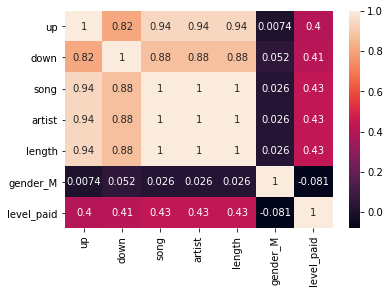

In [86]:
sns.heatmap(X.corr(), annot=True)

End